In [2]:
import pandas as pd

In [21]:
A = pd.DataFrame({'a': [1, 2, 3, 4, 3, 7, 5, 3], 'b': [6, 4, 3, 5, 7, 4, 3, 2]})

truth = [el or A['a'].between(5, 9).to_list()[i] for i, el in enumerate(A['a'].between(1, 2).to_list())]    
truth, print(A[truth])

   a  b
0  1  6
1  2  4
5  7  4
6  5  3


([True, True, False, False, False, True, True, False], None)

In [74]:
import numpy as np
import pandas as pd
import uproot as up
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use([hep.style.CMS, hep.style.firamath])

sname = "/disk/moose/lhcb/djdt/Lb2L1520mueTuples/MC/2016MD/fullSampleOct2021/job207-CombDVntuple-15314000-MC2016MD_Full-pKmue-MC.root"
fname = "/disk/moose/lhcb/djdt/Lb2L1520mueTuples/realData/2016MD/halfSampleOct2021/blindedTriggeredL1520Selec-collision-firstHalf2016MD-pKmue_Fullv9.root"

features = list(dict.fromkeys([
    'Lb_PT', 'Lb_IPCHI2_OWNPV', 'Lb_ENDVERTEX_CHI2', 'Lb_HOP',
    'L2_IPCHI2_OWNPV', 'L1_IPCHI2_OWNPV', 'LStar_ORIVX_CHI2', 'LStar_DIRA_OWNPV',
    'JPs_FD_ORIVX', 'p_PZ', 'p_P', 'K_PZ', 'K_P', 'K_PY', 'K_PT', 'p_PY', 'p_PT',
    'K_P', 'Lb_L1_cmult_0.5TrkISO', 'Lb_L2_cmult_0.5TrkISO', 'Lb_p_cmult_0.5TrkISO',
    'Lb_K_cmult_0.5TrkISO', 'Lb_L1_cc_asy_PT_0.5ConeISO', 'Lb_L2_cc_asy_PT_0.5ConeISO',
    'Lb_p_cc_asy_PT_0.5ConeISO', 'Lb_K_cc_asy_PT_0.5ConeISO', 'Lb_P', 'Lb_PT',
    'Lb_MINIPCHI2', 'Lb_DIRA_OWNPV', 'p_ETA', 'L1_ETA', 'L2_ETA',
    'Lb_IP01', 'Lb_IP23', 'JPs_DIRA_TOPPV', 'Lb_IP_OWNPV', 'p_TRACK_VeloCHI2NDOF',
    'Lb_TAUERR', 'Lb_DTF_PV_decayLengthErr', 'K_TRACK_VeloCHI2NDOF', 'Lb_DTF_PV_chi2', 'Lb_M'
]))

new_features = {
    'ABS_ARTANH_PZ_P': "np.abs(np.arctanh( p_PZ / p_P )-np.arctanh( K_PZ / K_P ))",
    'MAG_ARSINH_PY_PT': "np.sqrt((np.arcsinh( K_PY / K_PT )-np.arcsinh( p_PY / p_PT ))**2+(np.arcsinh( K_P / K_PT )-np.arcsinh( p_P / p_PT ))**2)",
    'SUM_CONE_ISO': " Lb_L1_cc_asy_PT_0.5ConeISO + Lb_L2_cc_asy_PT_0.5ConeISO + Lb_p_cc_asy_PT_0.5ConeISO + Lb_K_cc_asy_PT_0.5ConeISO ",
    'SUM_LIPCHI2': " L2_IPCHI2_OWNPV + L1_IPCHI2_OWNPV ",
    'LN_COS_THETA': "np.log(1-np.cos(np.arcsin( Lb_PT / Lb_P )))",
    'LN_LB_MINIPCHI2': "np.log( Lb_MINIPCHI2 )",
    'LN_COS_LBDIRA': "np.log(1-np.cos( Lb_DIRA_OWNPV ))",
    'LN_JPs_DIRA_TOPPV': "np.log( JPs_DIRA_TOPPV )",
    'LN_LStar_DIRA_OWNPV': "np.log( LStar_DIRA_OWNPV )"
}

feats = list(dict.fromkeys([
    'ABS_ARTANH_PZ_P', 'MAG_ARSINH_PY_PT', 'SUM_CONE_ISO', 'LN_COS_THETA',
    'SUM_LIPCHI2', 'JPs_FD_ORIVX', 'LN_LStar_DIRA_OWNPV',
    'LStar_ORIVX_CHI2', 'Lb_HOP', 'Lb_ENDVERTEX_CHI2',
    'Lb_IPCHI2_OWNPV', 'Lb_PT', 'LN_LB_MINIPCHI2', 'p_ETA',
    'L1_ETA', 'L2_ETA', 'Lb_IP01', 'Lb_IP23', 'LN_COS_LBDIRA', 
    'LN_JPs_DIRA_TOPPV', 'Lb_IP_OWNPV', 'p_TRACK_VeloCHI2NDOF', 
    'Lb_TAUERR', 'Lb_DTF_PV_decayLengthErr', 'K_TRACK_VeloCHI2NDOF', 
    'Lb_DTF_PV_chi2', 'Lb_M', 'category'
]))

def add_preselection_df_prefix(boolean_mask, prefix):
        preselection_features = []
        begin, end = False, False
        begin_position, end_position = 0, 0
        updated_mask = ''
        
        for i, char in enumerate(boolean_mask):
            updated_mask += char
            # Add the character to the current feature name
            if char == ' ' and not begin:
                # The beginning of a feature is when there is a space
                updated_mask = updated_mask[:-1]
                # Remove the space character added to the string
                updated_mask += f"{prefix}['"
                # This is the start of a new feature so add the appropriate prefix
                begin_position = i
                begin = True 
                # Set the begin position to the current position and update
                # the begin variable to show we have a beginning position
            elif char == ' ' and begin:
                # If a beginning position already exists this must be an end point
                updated_mask = updated_mask[:-1]
                # Remove the space character from the end of the string
                updated_mask += "']"
                # Add the closing bracket to match the dataframe wrapper
                end_position = i
                end = True
                # Set the end position and update the end variable to be true
            if begin and end:
                # We have both a begin and end point
                preselection_features.append(boolean_mask[begin_position + 1:end_position])
                begin, end = False, False
                # Reset the beginning and ending flags
        
        preselection_features = list(dict.fromkeys(preselection_features))
        # Remove all duplicates
        
        return updated_mask, preselection_features

In [75]:
preselect = "((( Lb_M01_Subst0_p2K <1019.461-12)|( Lb_M01_Subst0_p2K >1019.461+12))&((((((243716.98437715+ p_P **2)**0.5+ K_PE + L2_PE )**2-( p_PX + K_PX + L2_PX )**2-( p_PY + K_PY + L2_PY )**2-( p_PZ + K_PZ + L2_PZ )**2)**0.5)>2000)&(((((243716.98437715+ p_P **2)**0.5+ K_PE + L1_PE )**2-( p_PX + K_PX + L1_PX )**2-( p_PY + K_PY + L1_PY )**2-( p_PZ + K_PZ + L1_PZ )**2)**0.5)>2000))&((((((((880354.49999197+ p_P **2)**0.5+(243716.98437715+ K_P **2)**0.5+(0.26112103+ L2_P **2)**0.5)**2-( p_PX + K_PX + L2_PX )**2-( p_PY + K_PY + L2_PY )**2-( p_PZ + K_PZ + L2_PZ )**2)**0.5)>2320)&((( L2_ID <0)&( p_ID >0))|(( L2_ID >0)&( p_ID <0))))|((( L1_ID <0)&( p_ID >0))|(( L1_ID >0)&( p_ID <0))))&(((((((880354.49999197+ p_P **2)**0.5+(243716.98437715+ K_P **2)**0.5+(11163.69140675+ L1_P **2)**0.5)**2-( p_PX + K_PX + L1_PX )**2-( p_PY + K_PY + L1_PY )**2-( p_PZ + K_PZ + L1_PZ )**2)**0.5)>2320)&((( L1_ID <0)&( p_ID >0))|(( L1_ID >0)&( p_ID <0))))|((( L2_ID <0)&( p_ID >0))|(( L2_ID >0)&( p_ID <0)))))&(( Lb_M23 >3178.05)|( Lb_M23 <3000))&((((((( K_PE +(19479.95517577+ L2_P **2)**0.5)**2-( K_PX + L2_PX )**2-( K_PY + L2_PY )**2-( K_PZ + L2_PZ )**2)**0.5)>1865+20)|(((( K_PE +(19479.95517577+ L2_P **2)**0.5)**2-( K_PX + L2_PX )**2-( K_PY + L2_PY )**2-( K_PZ + L2_PZ )**2)**0.5)<1865-20))&((( L2_ID <0)&( p_ID >0))|(( L2_ID >0)&( p_ID <0))))|((( L1_ID <0)&( p_ID >0))|(( L1_ID >0)&( p_ID <0))))&((((((((11163.69140675+ K_P **2)**0.5+ L1_PE )**2-( K_PX + L1_PX )**2-( K_PY + L1_PY )**2-( K_PZ + L1_PZ )**2)**0.5)>3097+35)|(((((11163.69140675+ K_P **2)**0.5+ L1_PE )**2-( K_PX + L1_PX )**2-( K_PY + L1_PY )**2-( K_PZ + L1_PZ )**2)**0.5)<3097-35))&((( L1_ID <0)&( p_ID >0))|(( L1_ID >0)&( p_ID <0))))|((( L2_ID <0)&( p_ID >0))|(( L2_ID >0)&( p_ID <0))))&((((((((243716.98437715+ p_P **2)**0.5+(19479.95517577+ L2_P **2)**0.5)**2-( p_PX + L2_PX )**2-( p_PY + L2_PY )**2-( p_PZ + L2_PZ )**2)**0.5)>1865+20)|(((((243716.98437715+ p_P **2)**0.5+(19479.95517577+ L2_P **2)**0.5)**2-( p_PX + L2_PX )**2-( p_PY + L2_PY )**2-( p_PZ + L2_PZ )**2)**0.5)<1865-20))&((( L2_ID >0)&( p_ID >0))|(( L2_ID <0)&( p_ID <0))))|((( L1_ID >0)&( p_ID >0))|(( L1_ID <0)&( p_ID <0))))&((( p_PX * L1_PX + p_PY * L1_PY + p_PZ * L1_PZ )/( p_P * L1_P )<np.cos(1e-3))&(( p_PX * L2_PX + p_PY * L2_PY + p_PZ * L2_PZ )/( p_P * L2_P )<np.cos(1e-3))&(( K_PX * L1_PX + K_PY * L1_PY + K_PZ * L1_PZ )/( K_P * L1_P )<np.cos(1e-3))&(( K_PX * L2_PX + K_PY * L2_PY + K_PZ * L2_PZ )/( K_P * L2_P )<np.cos(1e-3)))&(( p_PX * K_PX + p_PY * K_PY + p_PZ * K_PZ )/( p_P * K_P )<np.cos(1e-3)))"

In [76]:
real_preselect, prefts = add_preselection_df_prefix(preselect, 'real_df')
all_requesting_fts = list(dict.fromkeys(features + prefts))

In [77]:
decayTree = ":DTT1520me/DecayTree"

with up.open(fname + decayTree) as f:
    real_df = f.arrays(["eventNumber"] + all_requesting_fts, library="pd")
    real_df.set_index("eventNumber", inplace=True)
    real_df = real_df.sample(frac=1, random_state=0)
    real_df = real_df[~real_df.index.duplicated(keep='first')]
    
real_df['category'] = 0
for feat_name, feat_expression in new_features.items():
    feat_expression_modified = add_preselection_df_prefix(feat_expression, 'real_df')[0]
    real_df[feat_name] = eval(feat_expression_modified)

# Now apply the preselection...
real_df = real_df[eval(real_preselect)]
real_df = real_df[feats]


/cvmfs/lhcbdev.cern.ch/conda/envs/default/2021-09-07_04-06/linux-64/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [78]:
sim_preselect, prefts = add_preselection_df_prefix(preselect, 'sim_df')
with up.open(sname + decayTree) as f:
    sim_df = f.arrays(["eventNumber", "Lb_BKGCAT"] + all_requesting_fts, library="pd")
    sim_df.set_index("eventNumber", inplace=True)
    sim_df = sim_df.sample(frac=1, random_state=0)
    sim_df = sim_df[~sim_df.index.duplicated(keep='first')]
    
sim_df['category'] = np.where(sim_df['Lb_BKGCAT'].isin([10, 50]), 1, 0)
# These are all background events

for feat_name, feat_expression in new_features.items():
    feat_expression_modified = add_preselection_df_prefix(feat_expression, 'sim_df')[0]
    sim_df[feat_name] = eval(feat_expression_modified)

sim_df = sim_df[eval(sim_preselect)]
sim_df = sim_df[feats]

In [79]:
df = pd.concat([sim_df, real_df], axis=0, ignore_index=True, sort=False)

In [80]:
import tensorflow as tf
df['category'].value_counts()

0    52129
1    40422
Name: category, dtype: int64

In [81]:
df.drop(['category'], axis=1, inplace=True)
model = tf.keras.models.load_model('neural_network/models/v6.0.5')
df.head()

,ABS_ARTANH_PZ_P,MAG_ARSINH_PY_PT,SUM_CONE_ISO,LN_COS_THETA,SUM_LIPCHI2,JPs_FD_ORIVX,LN_LStar_DIRA_OWNPV,LStar_ORIVX_CHI2,Lb_HOP,Lb_ENDVERTEX_CHI2,...,Lb_IP23,LN_COS_LBDIRA,LN_JPs_DIRA_TOPPV,Lb_IP_OWNPV,p_TRACK_VeloCHI2NDOF,Lb_TAUERR,Lb_DTF_PV_decayLengthErr,K_TRACK_VeloCHI2NDOF,Lb_DTF_PV_chi2,Lb_M
0,0.190737,0.326799,1.850129,-5.959903,2573.744243,1.422825,-0.002295,9.337301,1.016305,9.337301,...,0.471796,-0.777186,-0.000087,0.005783,1.346191,0.000031,0.215495,1.021230,55366.464844,5618.190990
1,0.353597,0.933926,1.189212,-4.140072,312.615688,0.345475,-0.008351,8.931516,0.921910,8.931516,...,0.248247,-0.777249,-0.002318,0.027401,1.378245,0.000054,0.142816,0.772324,10.869309,5583.473113
2,0.371461,0.395382,-0.165834,-6.603963,990.170116,0.087771,-0.004227,3.830041,1.176228,3.830041,...,0.146255,-0.777201,-0.000129,0.036817,1.254039,0.000059,0.219889,0.987966,7.201735,6130.476980
3,0.275890,0.340636,1.526137,-5.290453,893.732966,0.388696,-0.015316,7.431165,1.125189,7.431165,...,0.487692,-0.777189,-0.003526,0.010842,0.879305,0.000049,0.159914,0.343524,66550.820312,5992.149865
4,0.114569,0.171816,1.466196,-5.838069,1172.245672,0.233732,-0.001847,0.977275,1.325727,0.977275,...,0.204243,-0.777205,-0.000090,0.068227,1.285910,0.000039,0.184850,1.195050,20.623974,5237.589331


In [82]:
df_no_LbM = df.drop(['Lb_M'], axis=1)
# Need to normalise the features still you wombat!
df_no_LbM = (df_no_LbM - np.mean(df_no_LbM))/np.std(df_no_LbM)

In [83]:
df_no_LbM.head()

,ABS_ARTANH_PZ_P,MAG_ARSINH_PY_PT,SUM_CONE_ISO,LN_COS_THETA,SUM_LIPCHI2,JPs_FD_ORIVX,LN_LStar_DIRA_OWNPV,LStar_ORIVX_CHI2,Lb_HOP,Lb_ENDVERTEX_CHI2,...,Lb_IP01,Lb_IP23,LN_COS_LBDIRA,LN_JPs_DIRA_TOPPV,Lb_IP_OWNPV,p_TRACK_VeloCHI2NDOF,Lb_TAUERR,Lb_DTF_PV_decayLengthErr,K_TRACK_VeloCHI2NDOF,Lb_DTF_PV_chi2
0,-0.298933,-0.138747,0.334472,0.155394,0.239796,-0.006926,0.070580,-0.209320,-0.199371,-0.209320,...,4.016363,0.408846,0.497891,0.056266,-1.152075,0.425656,0.005665,-0.246560,-0.101230,1.203811
1,0.302754,1.664638,-0.097666,1.579354,-0.378362,-0.035996,0.008185,-0.245226,-0.335178,-0.245226,...,-0.110294,-0.214515,0.054396,0.002423,-0.372013,0.474635,0.005706,-0.550616,-0.453437,-0.179584
2,0.368754,0.064970,-0.983657,-0.348563,-0.193129,-0.042950,0.050675,-0.696628,0.030713,-0.696628,...,0.491968,-0.498916,0.390025,0.055234,-0.032217,0.284851,0.005714,-0.228179,-0.148299,-0.179675
3,0.015664,-0.097647,0.122631,0.679217,-0.219493,-0.034830,-0.063574,-0.377984,-0.042717,-0.377984,...,1.103731,0.453170,0.478318,-0.026730,-0.969505,-0.287733,0.005697,-0.479084,-1.060199,1.483320
4,-0.580338,-0.599104,0.083439,0.250724,-0.143352,-0.039011,0.075195,-0.949054,0.245801,-0.949054,...,0.918042,-0.337221,0.363523,0.056175,1.101150,0.333549,0.005679,-0.374768,0.144729,-0.179340


In [84]:
predictions = model.predict(df_no_LbM)

In [85]:
predictions = np.squeeze(predictions)
df['pred'] = predictions

In [86]:
nn_df = df[df['pred'] >= 0.50]
nn_df.shape

(31406, 28)

In [88]:
bins = np.linspace(4500, 6500, 100)
no_nn, _ = np.histogram(df['Lb_M'], bins=bins)
yes_nn, _ = np.histogram(nn_df['Lb_M'], bins=bins)

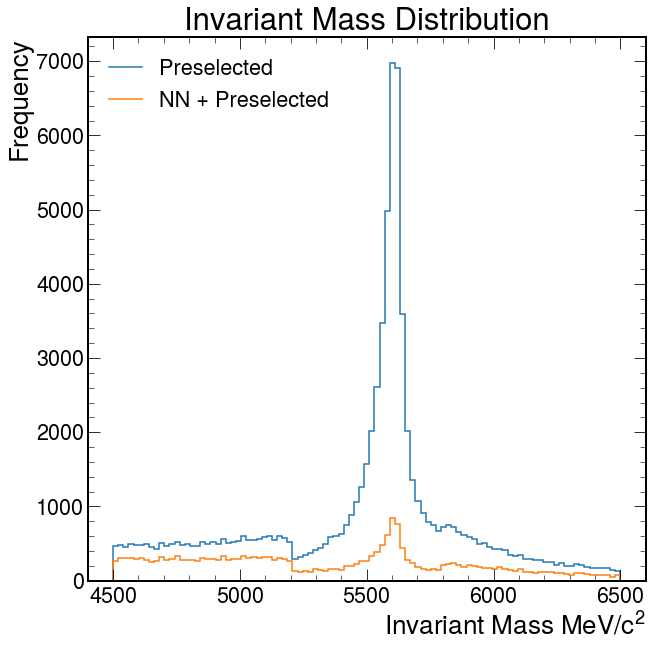

In [93]:
fig, ax = plt.subplots(1, 1)
hep.histplot([no_nn, yes_nn], bins, ax=ax, label=['Preselected', 'NN + Preselected'])
plt.ylabel('Frequency')
plt.xlabel(r'Invariant Mass $MeV/c^2$')
plt.legend(loc='upper left')
plt.title('Invariant Mass Distribution')
plt.show()